<a href="https://colab.research.google.com/github/Alexey-919/Alexey-919/blob/master/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%22%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%B6%D0%B8%D0%BB%D1%8C%D1%8F_%D0%B4%D0%BB%D1%8F_%D0%B0%D0%B3%D0%B5%D0%BD%D1%82%D1%81%D1%82%D0%B2%D0%B0_%D0%BD%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Проект: «Модель прогнозирования стоимости жилья для агентства недвижимости»**

In [1]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression # числовые признаки и числовой выходной признак
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import sklearn.metrics
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error,  median_absolute_error, r2_score

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## **Исследование структуры данных**

In [2]:
data = pd.read_csv('/content/drive/MyDrive/SkillFactory/Дипломный проект/data.csv')

In [ ]:
!pip freeze > requirements.txt # фиксируем библиотеки для воспроизводимости кода

In [3]:
data.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

**--> Описание признаков**

- **'status'** - статус продажи;
- **'private pool'** и **'PrivatePool'**- наличие собственного бассейна;
- **'propertyType'** - тип объекта недвижимости;
- **'street'** - адрем объекта;
- **'baths'** - количество ванных комнат;,
- **'homeFacts'** - сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
- **'fireplace'** - наличие камина;
- **'city'** - город;
- **'schools'** - сведения о школах в районе;
- **'sqft'** - площадь в футах;
- **'zipcode'** - почтовый индекс;
- **'beds'** - количество спален;
- **'state'** - штат;
- **'stories'** - количество этажей;
- **'mls-id'** и **'MlsId'** - идентификатор MLS (Multiple Listing Service, система
мультилистинга);
- **'target'** - цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [4]:
# Пропуски в данных
data.isna().mean().sort_values(ascending=False).round(4) * 100

private pool    98.89
mls-id          93.39
PrivatePool     89.31
fireplace       72.66
stories         39.96
baths           28.19
beds            24.20
MlsId           17.73
sqft            10.76
status          10.58
propertyType     9.21
target           0.66
city             0.01
street           0.00
zipcode          0.00
schools          0.00
state            0.00
homeFacts        0.00
dtype: float64

In [5]:
# Посмотрим на дубликаты
duplicate_rows = data[data.duplicated()]
duplicate_rows.shape

(50, 18)

In [6]:
# Удалим дублирующиеся записи
data = data.drop_duplicates()
data.shape

(377135, 18)

In [7]:
# Удалим пропуски в целевом признаке "target"
data.dropna(subset=['target'], inplace=True)
data = data.reset_index(drop=True)

In [8]:
# Удалим из признака 'target' лишние знаки
def clean_target(x):
  x = re.sub('[^0-9]', '', x) # производим замену всего, что кроме чисел на пустое (т.е. удаляем)
  x = int(x)
  return x

data['target'] = data['target'].apply(clean_target)

In [9]:
data.shape

(374655, 18)

In [10]:
columns_to_delete = ['mls-id', 'MlsId', 'fireplace', 'stories', 'street']
data.drop(columns_to_delete, axis=1, inplace=True)

In [11]:
data.isna().mean().sort_values(ascending=False).round(4) * 100

private pool    98.89
PrivatePool     89.29
baths           28.12
beds            24.27
sqft            10.70
status          10.48
propertyType     9.22
city             0.01
homeFacts        0.00
schools          0.00
zipcode          0.00
state            0.00
target           0.00
dtype: float64

In [12]:
data.describe(include='all')

,status,private pool,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,PrivatePool,target
count,335399,4151,340101,269308,374655,374621,374655,334560,374655,283726,374655,40120,3.746550e+05
unique,156,1,1279,226,318850,2019,295362,25373,4541,1147,39,2,NaN
top,for sale,Yes,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,yes,NaN
freq,156054,4151,91370,52072,7142,24406,4177,11853,2139,53072,114652,28686,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.447596e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.841482e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.869900e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.200000e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.820000e+05


In [13]:
df = data.copy()

## **Преобразование данных**

### **--> Признак "status"**

Термины, используемые в сфере продажи-покупки недвижимости:

- status - статус, состояние;

- estate - объект недвижимости;

- 'foreclosed' - ('foreclosure')- «лишён права выкупа».

  Это процесс, когда недвижимость переходит к кредитору из-за неуплаты ипотеки заёмщиком. Продажа foreclosure-недвижимости отличается от традиционных продаж.

- 'pre foreclosure' ('pre foreclosure auction') - «до выкупа», «аукцион до выкупа».

- 'under contract showing', 'under contract show', 'under contract', 'active under contract' - предложение о покупке уже сделано, но не принято продавцом окончательно, и недвижимость продолжают показывать другим потенциальным покупателям.

- 'under contract backups', 'active backup', 'backup contract' - предложение о покупке уже сделано и принято продавцом, однако он открыт для резервных предложений.

- 'contingency' - дополнительные обстоятельства (критерии, которым должен соответствовать продавец/покупатель до завершения сделки).

- 'contingency contract' - контракт на случай возникновения дополнительных обстоятельств.

- 'active contingency' - сделка уже практически состоялась, однако продавцу/покупателю для её завершения необходимо выполнить какие-то условия.

- 'insp inspection contingency' - ситуация, когда покупатель может официально проинспектировать объект недвижимости в определённый период времени.

- 'pending escape clause' - договор, предполагающий свободный выход сторон из него.

- 'pending backup wanted' - договор уже заключен, однако продавец хочет продолжать показывать недвижимость другим потенциальным покупателям и принимать резервные предложения.

- 'pending take backups' - условие,предполагающее, что продавец может принимать резерные предложения, если сделка с текущим покупателем не состоится.

- 'pending continue show financing' - в ожидании оплаты.

- 'pending continue show' - договор уже заключен, однако продавец хочет продолжать показывать недвижимость другим потенциальным покупателям на случай, если текущая сделка не состоится.

- 'pending insp finance' - в ожидании проплаты.

- 'pending inspection' - в ожидании проверки.

- 'due diligence period' - период, в течение которого покупатель имеет право проинспектировать недвижимость и изучить всю важную для заключения сделки информацию.

- 'activated' - «активен», открыт для покупки.

- 'active with contract' - продавец уже принял предложение о покупке, однако сделка ещё не закрыта.

- 'active option' = = active with contract = = 'active option contract' = = contingency period = = due diligence period - «активный»

- 'active with offer' - продавец принял предложение о покупке, однако ищет резервные предложения на случай, если сделка с текущим покупателем не состоится.

- 'active auction', 'auction active', 'auction' - продажа недвижимости с помощью аукциона.

- contingency, contingencies - случайность, непредвиденные обстоятельства.

- contingent - условный. В сфере недвижимости, когда дом указан как условный, это означает, что предложение было сделано и принято, но до завершения сделки должны быть выполнены некоторые дополнительные критерии.

- cooling-off period - период, в течение которого покупатель может расторгнуть договор после завершения сделки.

In [14]:
df.status.nunique()

156

In [15]:
def make_status(x):
    if x.startswith('Coming soon'): x = 'coming_soon'
    x = x.replace('Showing', 'show')
    x = x.replace('Pf', 'pre foreclosure')
    x = x.replace('Ps', 'pending Sale')
    x = x.replace('Bckp', 'backups')
    x = x.replace('insp', 'inspection')
    x = x.lower()
    x = re.sub('[^a-z:]', ' ', x)
    x = re.sub(r'\b\w{,2}\b', '', x)
    x = re.sub(r'\s+', ' ', x)
    return x.strip()

df['status'] = df['status'].fillna('other')
df['status'] = df['status'].apply(make_status)
df['status'].value_counts()

for sale                 199520
active                   105649
other                     39256
foreclosure                6020
new construction           5458
                          ...  
pending backup wanted         1
conditional contract          1
pending bring backup          1
temporary active              1
backup                        1
Name: status, Length: 82, dtype: int64

In [16]:
# Меняем пустые значения на 'other'
df['status'] = df['status'].apply(lambda x: 'other' if x == '' else x)

In [17]:
# Заменим некоторые слова для приобретения единой формы
old_words = ['auction active', 'pending continue show financing', 'activated']
new_words = ['active auction', 'pending continue show', 'active']

for i in range(0, len(new_words)):
    df['status'] = df['status'].apply(lambda x:
                                    x.replace(old_words[i], new_words[i]))

new_string = ['active with contract', 'active option contract',
              'contingency period', 'due diligence period']

for i in range(0, len(new_string)):
    df['status'] = df['status'].apply(lambda x: 'active option'
                                    if (-1 != x.find(new_string[i])) else x)

df['status'] = df['status'].apply(lambda x: 'for rent'
                                        if (-1 != x.find('for rent')) else x)

df['status'] = df['status'].apply(lambda x: 'active auction'
                                  if x == 'auction' else x)

df['status'].nunique()

72

In [18]:
top_status = df['status'].value_counts()[:30].index
df['status'] = df['status'].apply(lambda x: x
                                              if x in top_status else 'other')

In [19]:
df['status'].value_counts()

for sale                             199520
active                               105651
other                                 41159
foreclosure                            6020
new construction                       5458
pending                                4826
pre foreclosure                        2004
under contract show                    1987
active auction                         1330
pre foreclosure auction                1281
active under contract                   718
under contract                          702
new                                     690
contingent                              581
price change                            563
for rent                                412
foreclosed                              294
under contract backups                  253
contingent finance and inspection       245
pending continue show                   205
contingent show                         115
back market                             112
option pending                  

### **--> Признак "propertyType"**

Типы домов, жилищ, и их основные характеристики:

- Apartment - съёмная квартира (нельзя купить);
- Condo - кондоминиум (можно купить);
- Co-Op - квартира в жилищном кооперативе;
- Single-Family (Detached, Tiny Home) -односемейный (отдельный,
маленький) дом;

- townhome, townhouse — таунхаус;

- Cape Cod - черепичная крыша, облицовка деревянным сайдингом, дверь в центре здания, окна по бокам, один-два этажа;

- Colonial home - минимум два этажа, симметрия, лестница в центре здания, строгий внешний вид;

- Contemporary - чистые, простые линии, нейтральные цвета, натуральные текстуры;

- Cottage - небольшая уютная веранда, небольшие жилые помещения;

- Craftsman - деревянные элементы ручной работы, выступающие балки,
большие колонны;

- Greek Revival - большие белые колонны, украшения в греческом стиле,
нарядный вход;

- Farmhouse - прямоугольная планировка, большое крыльцо, амбарная
крыша;

- French Country - влияние прованса, облицовка камнем, состаренный
вид;

- Mediterranean - белая штукатурка, дерево и камень в тёплых тонах,
черепичные крыши, элементы испанских и итальянских вилл;

- Midcentury Modern - сочетание плавных природных и строгих
геометрических линий, гладкость, лаконичность, большие окна;

- Ranch - один этаж, низкая крыша, открытые жилые помещения, задний
двор;

- Split-Level - жилые помещения разделены короткими лестничными
пролётами;

- Tudor - деревянные балки, каменная кладка, асимметричная крутая
двускатная крыша;

- Victorian (Queen Anne Houses) - два-три и более этажей, богатый декор, крутая двускатная крыша, небольшие башенки, яркий фасад;

- European Houses style — кирпич или камень, высокая крутая крыша,
высокие окна, часто со ставнями, традиционные декоративные детали
(фронтоны, замковые камни);

- log home — деревянный дом.

- mortgage - ипотека

In [20]:
df['propertyType'].isna().sum()

34554

In [21]:
df['propertyType'] = df['propertyType'].fillna('no data') # Меняем пропуски на "no data"
df['propertyType'] = df['propertyType'].apply(lambda x: 'no data' # Также убираем отсутствие значений и 'unknown'
                                        if x ==' ' or x=='unknown' else x)
df['propertyType'] = df['propertyType'].apply(lambda x: x.lower()) # Приводим к нижнему регистру

df['propertyType'].value_counts()

single-family home                                             91370
single family                                                  61886
condo                                                          42368
no data                                                        34708
single family home                                             31725
                                                               ...  
contemporary, farmhouse                                            1
2 stories, traditional, mediterranean, texas hill country          1
1 story, contemporary, traditional, mediterranean                  1
loft, warehouse                                                    1
bilevel, converted dwelling, loft with bedrooms, condo/unit        1
Name: propertyType, Length: 1270, dtype: int64

Удалим строки со значением "land", так как нас интересует именно недвижимость, а не земельные участки.

In [22]:
df['propertyType'] = df['propertyType'].apply(lambda x: x.replace('lot/land', 'land'))
df['propertyType'] = df['propertyType'].apply(lambda x: 'land' if (-1 != x.find('land')) else x)

ind_land_drop = df[df['propertyType']=='land'].index

df.drop(ind_land_drop,  inplace=True)
df = df.reset_index(drop=True)

Давайте немного поработаем с категориями признака, попробуем навести небольшой порядок.

In [23]:
old = ['one', 'two', '2-', 'stories', '1 1/2', 'tri-', 'single family',
       'singlefamilyresidence', 'townhome',   'bi', 'bi-', 'multi family',
       'hi-', 'high ', 'condominium',  '4 plex', 'other', 'ca2 n', 'cape cod',
       'mid century', 'mid-century',  'mo2 le', 'mo2le', ' / ','mfd',
       'co-op', 'coop',  'modernist', 'key west', 'farm house',
       'queen anne', ' -level', 'floors', 'mobile home', 'manuf/mobile',
       'less than 4 story', 'historic/older', 'quad']

new = ['1', '2', '2 ', 'story',  '1.5', '3 ', 'single-family',
       'single-family', 'townhouse',  '2 ', '2 ',  'multi-family',
       'high-', 'high-', 'condo',  '4-plex', 'other style', 'cabin', 'cape',
       'midcentury', 'midcentury', 'mobile', 'mobile', '/', 'manufactured',
        'cooperative', 'cooperative',  'modern', 'elevated', 'farmhouse',
        'victorian', ' level',  'story', 'manufactured', 'manufactured',
        '3 story', 'historical', '4']

for i in range(0,len(new)):
    df['propertyType'] = df['propertyType'].apply(lambda x:
                                                  x.replace(old[i], new[i]))

In [24]:
df['propertyType'].value_counts()

single-family home                                             123095
single-family                                                   62065
condo                                                           42424
no data                                                         34708
townhouse                                                       18344
                                                                ...  
other style, ranch                                                  1
traditional, colonial, federal                                      1
condo/townhouse, french, split level                                1
colonial, duplex                                                    1
2 level, converted dwelling, loft with bedrooms, condo/unit         1
Name: propertyType, Length: 1229, dtype: int64

In [25]:
# Выделим этажность домов
df['Property_story'] = df['propertyType'].apply(lambda x:
                                        x if -1!= x.find('story') else 'no')

In [26]:
# Dыделим индексы строк, имеющие данные об этажности
ind_story = df[df['Property_story']!='no'].index
ind_story

Int64Index([    14,     90,    106,    154,    166,    181,    198,    277,
               342,    469,
            ...
            342645, 342653, 342720, 342724, 342828, 342830, 342922, 342982,
            343108, 343112],
           dtype='int64', length=7712)

In [27]:
# Удаление сведений, относящихся к этажности для перезаписи в признак 'propertyType'
def type_del_story(x):
    s = x.split(',')
    for i in range(0, len(s)):
        if s[i].find('story')!=-1:
            if len(s)==1 and i==0:
                s[i] = 'other'
            if len(s)>1:
                s[i] = ','
            if len(s)>1 and i==0:
                s[i]=''
        x = '' .join(s).strip()
    return x

df.loc[ind_story, 'propertyType'] = df['Property_story'][ind_story].apply(type_del_story)

df['propertyType'][ind_story].value_counts()

other                                       3641
detached,                                   2252
traditional                                  540
contemporary                                 266
detached, spanish/mediterranean              120
                                            ... 
texas hill country a-frame                     1
colonial contemporary                          1
split level contemporary traditional           1
contemporary ranch traditional craftsman       1
multi-level patio home townhouse               1
Name: propertyType, Length: 127, dtype: int64

In [28]:
df.drop('Property_story', axis=1, inplace=True)

В признаке 'propertyType' оставляем основные типы домов

In [29]:
# Присвоение полям новых названий в соответствии с найденной подстрокой

new = ['mediterranean', 'english', 'georgian', 'florida','spanish',
        'lake house', 'tudor', 'victorian', 'ranch', 'townhouse',
        'single-family','multi-family', 'single detached', 'detached',
        'high-rise', 'colonial', 'traditional',
        'condo', 'contemporary', 'other style', 'bungalow', 'craftsman',
        'cape cod','cooperative', 'a-frame',  'custom', 'loft',
        'multi-level', 'attached', 'manufactured',  'side-by-side',
        'cottage',  'french', 'cluster home', 'garden home',
        'farmhouse', 'elevated',  'historical', 'transitional','penthouse',
        'modern']

for i in range(0, len(new)):
    df['propertyType'] = df['propertyType'].apply(lambda x: new[i]
                                            if (-1 != x.find(new[i])) else x)

In [30]:
# Присвоение полям новых значений с изменением
old = ['cape','log']
new = ['cape cod','log home']

for i in range(0,len(new)):
    df['propertyType'] = df['propertyType'].apply(lambda x: new[i]
                                              if -1!=x.find(old[i])  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'historical'
                        if (x=='historic') or (x=='historic vintage') else x)

In [31]:
df['propertyType'].value_counts()

single-family      185160
condo               42772
no data             34708
townhouse           27006
multi-family        12169
                    ...  
bermuda                 1
back-to-back            1
split,                  1
resort property         1
prairie                 1
Name: propertyType, Length: 144, dtype: int64

In [32]:
df['propertyType'] = df['propertyType'].apply(lambda x: 'other style'
                            if (x=='no data') or (x=='other')  else x)

In [33]:
# С целью уменьшения числа категорий, выберем топ 50 или топ 100 типов стилей домов.
top_type = df['propertyType'].value_counts()[:30].index
df['propertyType'] = df['propertyType'].apply(lambda x: x
                                            if x in top_type else 'other style')

In [34]:
df['propertyType'].value_counts()

single-family         185160
condo                  42772
other style            40939
townhouse              27006
multi-family           12169
traditional             7171
detached                5305
cooperative             3834
manufactured            3500
contemporary            3226
ranch                   3104
high-rise               1969
colonial                1342
mediterranean            875
apartment                797
florida                  749
transitional             569
bungalow                 551
garden home              321
cape cod                 313
craftsman                308
tudor                    156
cluster home             155
custom                   146
multiple occupancy       145
victorian                140
spanish                  129
split-level              119
modern                   119
federal                  115
Name: propertyType, dtype: int64

### **--> Признак "homeFacts"**

Признак "homeFacts" содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры. Поэтому выделим эти данные. Для этого приведем содежимое данного признака к формату .json и формируем новые признаки.

In [35]:
# Заменим пропуски на '0'
df['homeFacts'] = df['homeFacts'].apply(lambda x: x.replace('None', '0'))

In [36]:
# Приводим значения с апострофами в правильный вид
old = ["Attch'd", "Addtn'l", '"closet"', "Hennen\'s", "Penske's", "Req'd"]
new = ['Attch`d', 'Addtn`l', '`closet`', 'Hennen`s', 'Penske`s', 'Req`d']

for i in range(0, len(old)):
    df['homeFacts'] = df['homeFacts'].apply(lambda x: x.replace(old[i], new[i]))

df['homeFacts'] = df['homeFacts'].apply(lambda x: x.replace("'",'"')) # Меняем одиночные кавычки на двойные

In [37]:
# Посмотрим как преобразуется признак в формат json
example = df['homeFacts'][200]
examination = json.loads(example)
examination

{'atAGlanceFacts': [{'factValue': '2004', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Forced air', 'factLabel': 'Heating'},
  {'factValue': 'Central', 'factLabel': 'Cooling'},
  {'factValue': '2 spaces', 'factLabel': 'Parking'},
  {'factValue': '8,964 sqft lot', 'factLabel': 'lotsize'},
  {'factValue': '$108', 'factLabel': 'Price/sqft'}]}

In [38]:
# Проверяем правильность парсинга в json формат
for i in range(0,len(df)):
    example = df['homeFacts'][i]
    try:
        examination = json.loads(example)
    except:
        print(i)

In [39]:
def app(x, k):
    js = json.loads(x)
    return js['atAGlanceFacts'][k]['factValue']

# Вытягиваем необходимые данные
df['Year_built'] = df['homeFacts'].apply(lambda x: app(x, 0))
df['Remodeled_year'] = df['homeFacts'].apply(lambda x: app(x, 1))
df['Heating'] = df['homeFacts'].apply(lambda x: app(x, 2))
df['Cooling'] = df['homeFacts'].apply(lambda x: app(x, 3))
df['Parking'] = df['homeFacts'].apply(lambda x: app(x, 4))
df['lotsize'] = df['homeFacts'].apply(lambda x: app(x, 5))
df['Price/sqft'] = df['homeFacts'].apply(lambda x: app(x, 6))

#### **--> Признак 'Year_built'**

In [40]:
# Создаем значение 0 в признаке "год постройки" по условию
df['Year_built'] = df['Year_built'].apply(lambda x: '0' if x == 0 or x == 'No Data' or x == '' or len(x) > 4 else x)
df['Year_built'] = df['Year_built'].astype(int)
df['Year_built'].value_counts()

0       36294
2019    32024
2006     7928
2005     7424
2007     7053
        ...  
1809        1
1823        1
1807        1
1799        1
1804        1
Name: Year_built, Length: 224, dtype: int64

In [41]:
# Определим индексы "выбросов"в меньшую сторону.
ind_built_min= df[(df['Year_built'] > 0) & (df['Year_built'] < 1700)].index
df['Year_built'][ind_built_min]

136430    1208
157180    1057
240359    1060
284623    1019
Name: Year_built, dtype: int64

In [42]:
# Определим индексы "выбросов" в большую сторону.
ind_built_max = df[df['Year_built'] >= 2022].index
df['Year_built'][ind_built_max]

90756     2022
100697    2022
118006    2022
125908    2022
149374    2025
163324    2022
215991    2022
252686    2022
285207    2025
320476    2022
Name: Year_built, dtype: int64

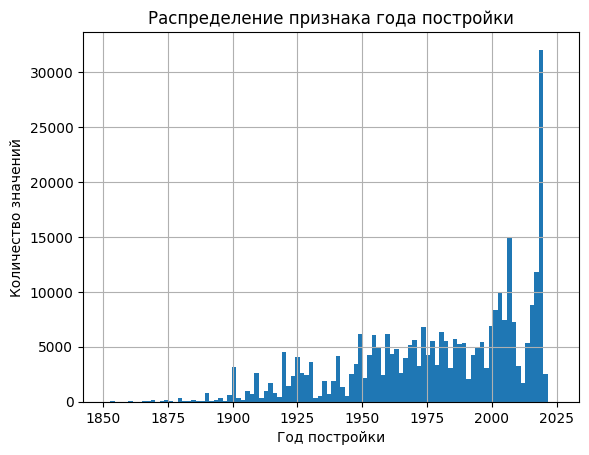

In [43]:
plt.xlabel('Год постройки')
plt.ylabel('Количество значений')
plt.title('Распределение признака года постройки')
df['Year_built'][df['Year_built'] > 1850].hist(bins=100)
plt.show();

#### **--> Признак 'Remodeled_year'**

In [44]:
# Признак "год реконструкции"
df['Remodeled_year'] = df['Remodeled_year'].apply(lambda x: '0' if x == 0 or x == '' else x)
df['Remodeled_year'] = df['Remodeled_year'].astype(int)
df['Remodeled_year'].value_counts()

0       195304
2006      5477
2005      4769
2007      4348
2008      3757
         ...  
1869         1
1853         1
1870         1
1845         1
1862         1
Name: Remodeled_year, Length: 150, dtype: int64

In [45]:
# Также определим индексы "выбросов" в меньшую сторону.
ind_remodeled_min = df[(df['Remodeled_year'] > 0) & (df['Remodeled_year'] < 1700)].index
df['Remodeled_year'][ind_remodeled_min]

Series([], Name: Remodeled_year, dtype: int64)

In [46]:
# Определим индексы "выбросов" в большую сторону.
ind_remodeled_max = df[df['Remodeled_year'] >= 2021].index
df['Remodeled_year'][ind_remodeled_max]

50832     2021
77401     2021
154528    2021
161529    2021
323680    2021
337058    2021
Name: Remodeled_year, dtype: int64

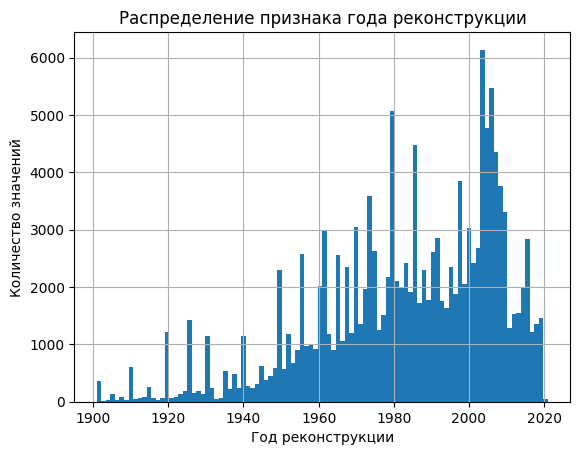

In [47]:
plt.xlabel('Год реконструкции')
plt.ylabel('Количество значений')
plt.title('Распределение признака года реконструкции')
df['Remodeled_year'][df['Remodeled_year'] > 1900].hist(bins=100)
plt.show();

In [48]:
df.loc[ind_built_min, 'Year_built'] = 0

df.loc[ind_built_max, 'Year_built'] = 2022

df.loc[ind_remodeled_min, 'Remodeled_year'] = 0

In [49]:
# Преобразуем признак год постройки в возраст здания
max = df['Year_built'].max()
df['Year_built'] =  df['Year_built'].apply(lambda x: float(max-x) if x!=0 else -1.0)
df['Year_built']

0           3.0
1           3.0
2          61.0
3          16.0
4         102.0
          ...  
343199     32.0
343200     98.0
343201     72.0
343202     -1.0
343203      3.0
Name: Year_built, Length: 343204, dtype: float64

In [50]:
# По аналогии создадим признак возраст с момента реконструкции
max = df['Remodeled_year'].max()
df['Remodeled_year'] =  df['Remodeled_year'].apply(lambda x: float(max-x) if x!=0 else -1.0)
df['Remodeled_year'].value_counts()

-1.0      195304
 15.0       5477
 16.0       4769
 14.0       4348
 13.0       3757
           ...  
 152.0         1
 168.0         1
 151.0         1
 176.0         1
 159.0         1
Name: Remodeled_year, Length: 150, dtype: int64

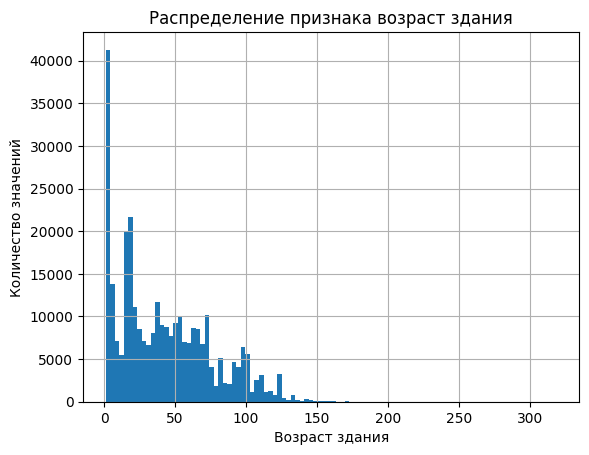

In [51]:
plt.xlabel('Возраст здания')
plt.ylabel('Количество значений')
plt.title('Распределение признака возраст здания')
df['Year_built'][df['Year_built'] > 0].hist(bins=100)
plt.show();

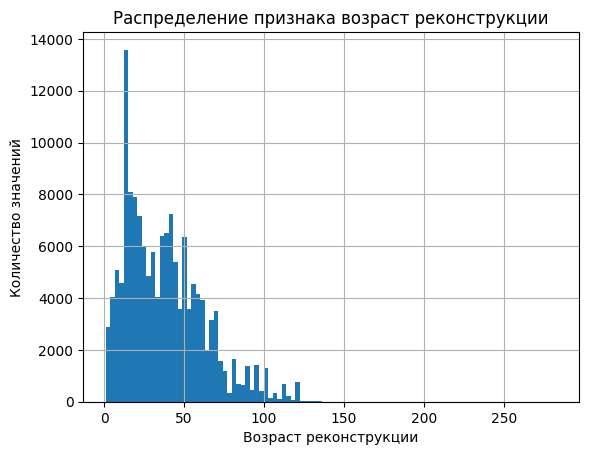

In [52]:
plt.xlabel('Возраст реконструкции') # Чем показатель меньше, тем лучше
plt.ylabel('Количество значений')
plt.title('Распределение признака возраст реконструкции')
df['Remodeled_year'][df['Remodeled_year'] > 0].hist(bins=100)
plt.show();

#### **--> Признак "Parking"**

In [53]:
# Сделаем признак бинарным: 0 - нет паркинга, 1 - есть паркинг.
df['Parking'] = df['Parking'].apply(lambda x: 0 if x == 0 or x == '' or x == 'No Data' or x == 'No' else 1)
df['Parking'].value_counts()

1    185255
0    157949
Name: Parking, dtype: int64

#### **--> Признаки 'Heating' и 'Cooling'**

Два признака, 'Heating' и 'Cooling', существенно влияют на цену недвижимости. Поэтому необходимо привести данные этих показателей в пригодную форму для использования в моделях прогноза цен на недвижимость.

In [54]:
# Функция для первоначального парсинга признаков 'Heating' и 'Cooling'
patterns = "[!#$%&()'*+.:;<=>?@[\]^_`{|}~—\"]+"
def parsing (x):
    if (x == 0) or (x == '0') or (x == '') or (x == 'No Data'):
        x = 'No'
    x = x.title()
    x = re.sub(patterns, ' ', x)
    if len(x) > 0 and x[0] == ',':
        x = x[1:].strip()
    return x

df['Heating'] = df['Heating'].apply(parsing)

In [55]:
df['Heating'].value_counts()

Forced Air                                                      132503
No                                                               92528
Other                                                            28059
Heat Pump                                                         8731
Central Air                                                       7814
                                                                 ...  
Zoned Heating, Wall Unit Heating, Forced Air Heating                 1
Baseboard, Spacewallunit                                             1
Hot Air, Stove-Pellet                                                1
Natural Gas, Space Heater                                            1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor         1
Name: Heating, Length: 1887, dtype: int64

In [56]:
#  Выделение индексов строк
ind_H = df[df['Heating']=='Central Air'].index
df['Cooling'][ind_H].value_counts()

Has Cooling    7800
                 14
Name: Cooling, dtype: int64

In [57]:
# Изменеие 'Has Cooling' признака 'Cooling' на 'Central Air' признака 'Heating'.
df.loc[ind_H,'Cooling'] = df['Heating'][ind_H]

In [58]:
df['Cooling'][ind_H].value_counts()

Central Air    7814
Name: Cooling, dtype: int64

In [59]:
# Выделение индексов строк
ind_C = df[df['Cooling']=='Central Heating'].index
df['Heating'][ind_C].value_counts()

Electric Heat                                           1470
Natural Gas Heat                                        1134
Central Cooling                                           71
Electric Heat, Natural Gas Heat                           67
Ceiling Fan, Central Cooling                              25
Other Heating Fuel  See Remarks                           16
Propane  Owned                                             5
Electric Heat, Propane  Owned                              2
Electric Heat, Solar Heat                                  2
Ceiling Fan, Central Cooling, Electric Cooling             2
Central Cooling, Wall-Window A/C                           2
Electric Cooling                                           2
Wall-Window A/C                                            1
Natural Gas Heat, Solar Heat                               1
Central Cooling, Zoned Cooling                             1
Ceiling Fan, Electric Cooling                              1
Ceiling Fan             

In [60]:
# Изменение  признака 'Heating' и  признака 'Cooling'.'Central Heating'
def change(x):
    if -1!=x.find('Gas'):
        x = 'Central Heating '+'Gas'
    if -1!=x.find('Electric '):
        x = 'Central Heating '+'Electric '
    return x

df.loc[ind_C, 'Heating'] = df['Heating'][ind_C].apply(change)
df['Heating'][ind_C].value_counts()

Central Heating Electric                                1479
Central Heating Gas                                     1202
Central Cooling                                           71
Ceiling Fan, Central Cooling                              25
Other Heating Fuel  See Remarks                           16
Propane  Owned                                             5
Central Cooling, Wall-Window A/C                           2
Attic Fan, Ceiling Fan, Central Cooling                    1
Ceiling Fan, Central Cooling, Zoned Cooling                1
Central Building Cooling, Central Individual Cooling       1
Ceiling Fan                                                1
Wall-Window A/C                                            1
Central Cooling, Zoned Cooling                             1
Central Building Cooling                                   1
Name: Heating, dtype: int64

In [61]:
df.loc[ind_C,'Cooling']= 'Central'
df['Cooling'][ind_C].value_counts()

Central    2807
Name: Cooling, dtype: int64

In [62]:
ind_CE =df[df['Cooling']=='Electric Heating'].index
df['Heating'][ind_CE].value_counts()

Refrigeration                                                                                   171
Refrigeration, Ceiling Fan S                                                                    144
Refrigeration, Ceiling Fan S , Programmable Thermostat                                           23
No                                                                                                9
Electric Cooling                                                                                  6
Refrigeration, Programmable Thermostat                                                            5
Central Cooling                                                                                   5
1 Window/Wall Air Conditioning Unit                                                               3
Programmable Thermostat                                                                           3
1 Air Conditioner                                                                                 2


In [63]:
df.loc[ind_CE, 'Cooling'] = df['Heating'][ind_CE]
df.loc[ind_CE, 'Heating'] = 'Electric Heating'

In [64]:
fnd =['Air Conditioning','Air Conditionings','Air Conditioner','Air Conditioners','A/C','Ac']

def dop_Heat(x):
    if (-1!=x.find('Forced Air') or -1!=x.find('Heat Pump')) and -1!=x.find('Gas'):
        x='Forced Gas'
    if (-1!=x.find('Forced Air') or -1!=x.find('Heat Pump')) and -1!=x.find('Electric'):
        x='Forced Electric'
    if -1!=x.find('Heat Pump') or x=='Forcedair':
         x='Forced'
    if -1!=x.find('Forced Air') or x=='Forced Warm Air':
        x='Forced'
    for i in range(0, len(fnd)):
        x = x.replace(fnd[i], '')
    if -1!=x.find('Central Air'):
        x='Central'
    if -1!=x.find('Central') and -1!=x.find('Electric'):
        x='Central Electric'
    if -1!=x.find('Central') and -1!=x.find('Gas'):
        x='Central Gas'
    if x== 'Electric':
        x='Central Electric'
    return x

df['Heating'] = df['Heating'].apply(dop_Heat)

In [65]:
gas = ['Gas', 'Forced Gas', 'Central Gas', 'Electric, Gas']
central = ['Central Electric', 'Central Gas', 'Central Furnace', 'Central Heating']
electric = ['Central Electric', 'Forced Electric', 'Electric, Gas']
name_change = ['Wall', 'Refrigeration', 'Baseboard', 'Hot Water', 'Stove', 'Radiator']
def in_gce(x):
    x = x.strip()
    x = x.replace('Units', 'Unit')
    x = x.replace('Unit S', 'Unit')
    if ((-1!=x.find('Gas') or -1!=x.find('Propane')) and (x not in gas)):
        x='Gas'
    if (-1!=x.find('Central') and (x not in central)):
        x='Central'
    if (-1!=x.find('Electric') and (x not in electric)):
        x='Electric'
    for i in range(0, len(name_change)):
        if -1!=x.find(name_change[i]):
            x = name_change[i]
    if -1!=x.find('Heat') and -1==x.find('Heating'):
        x='Heating'
    if -1!=x.find('Heating') and (x not in ['Central Heating', 'Heating System']):
        x='Heating'
    if -1!=x.find('Window Unit') or x=='Window':
        x = 'Window Unit'
    if  -1!=x.find('Hot Air'):
        x='Forced'
    return x

df['Heating'] = df['Heating'].apply(in_gce)

In [66]:
ind_Heat = df['Heating'].value_counts()[:'Stove'].index
ind_Heat

Index(['Forced', 'No', 'Other', 'Central Electric', 'Central', 'Gas',
       'Baseboard', 'Wall', 'Electric', 'Heating System', 'Central Gas',
       'Forced Gas', 'Radiant', 'Forced Electric', 'Central Furnace',
       'Central Heating', 'Heating', 'Electric, Gas', 'Hot Water',
       'Refrigeration', 'Oil', 'Window Unit', 'Radiator', 'Stove'],
      dtype='object')

In [67]:
# Уменьшаем количество категорий признака 'Heating'
df['Heating'] = df['Heating'].apply(lambda x: x if x in ind_Heat else 'other')

In [68]:
df['Cooling'] = df['Cooling'].apply(parsing)

In [69]:
fnd =['Air Conditioning','Air Conditionings','Air Conditioner','Air Conditioners','A/C','Ac']
name_change = ['Central Air','Hot Air','Window Unit','Refrigeration','Air Purification System',
               'Common Heating/Cooling', 'Zoned','Baseboard','Wall','Other','No']
def dop_Cool(x):
    x = x.strip()
    x = x.replace('Fan S', 'Fan')
    x = x.replace('Unit S', 'Unit')
    for i in range(0, len(fnd)):
        x = x.replace(fnd[i], 'Air Conditioning')
    if -1!=x.find('Air Conditioning'):
        x='Air Conditioning'
    if -1!=x.find('Central') and -1==x.find('Air'):
        x='Central Air'
    for i in range(0, len(name_change)):
        if -1!=x.find(name_change[i]):
            x = name_change[i]
    if -1!=x.find('Central') and -1!=x.find('Electric'):
        x='Central Electric'
    if -1!=x.find('Central') and -1!=x.find('Gas'):
        x='Central Gas'
    if x== 'Electric':
        x='Central Electric'
    if -1!=x.find('Heat Pump') or -1!=x.find('Forced Air'):
        x='Forced Air'
    if -1!=x.find('Window') and -1==x.find('Unit'):
        x = 'Window Unit'
    if -1!=x.find('Ceiling'):
        x = 'Ceiling Fan'
    if -1!=x.find('Air Purification System'):
        x = 'Air Purification System'
    if -1!=x.find('Evaporative'):
        x = 'Evaporative Cooling'
    return x

df['Cooling'] = df['Cooling'].apply(dop_Cool)

In [70]:
ind_Cool = df['Cooling'].value_counts()['Zoned':].index
ind_Cool

Index(['Zoned', 'Yes', 'Ductless Hp-Mini Split', '1', 'Geothermal',
       '2 Or More Units, Electric', 'Contact Manager', 'Natural Gas Heat',
       'Radiant Heat', 'Attic Fan',
       ...
       'Cooling, Heating', 'Individual Cooling', 'Heat Strip', 'Dual',
       'Dehumidifier', 'Radiant Heat, Radiator Heat, Tankless Water Heater',
       'Hot Water, Radiator Heat, Stove Heat', 'Radiant Floor',
       'Ductless/Mini-Split System',
       '90  High Efficiency, Ductless Hp-Mini Split, Tankless Water Heater'],
      dtype='object', length=144)

Все остальные значения после признака 'Zoned' отнесем к 'Other'

In [71]:
df['Cooling'] = df['Cooling'].apply(lambda x: x if x in ind_Cool else 'Other')

### **--> Признак "schools"**

Признак "schools" как и признак "homeFacts" также содержит отдельные данные, имеющие влияние на оценку недвижимости (дома, квартиры). Поэтому выделим эти данные. Для этого также приведем содежимое данного признака к формату .json и сформируем новые признаки.

In [72]:
df['schools'] = df['schools'].apply(lambda x: x.replace('None', '0')) # Меняем пропуски на 0.

In [73]:
old = ["O\'", " O`,",  "'s", "\'Duke\'", "B\'Nai", "B\'inai",  "L\'Ouver", "L\'ouver",  "L\'Banos", "L\'Dovid",
              "Lil\'", "D\'",  "d\'Evelyn", "Q\'", "Loggers\'", "Teach N\'",  "K\'Tana", "R&D`",  "Citizens\'",  "Kids\'",
              "Girls\' ", "d\'Chassidei", "d\'Gur", "d\'Rav", "Pe\'Er", "Be\'Er", "Kids \'R\' Kids", "\'joe\' ",
              "Meadow\'S", "Sheriff\'S", "Friends\' ", "\'Mother\'", "Int\'L", "\'buddy\'"]

new = ['O`',  " O\', ", '`s', '`Duke`', 'B`Nai', 'B`inai',  'L`Ouver', 'L`Ouver', 'L`Banos', 'L`Dovid',
              'Lil`', 'D`', 'd`Evelyn', 'Q`', 'Loggers`', 'Teach N`', 'K`Tana', "R&D\'",   'Citizens`', 'Kids`',
              'Girls` ',  'd`Chassidei','d`Gur', 'd`Rav', 'Pe`Er', 'Be`Er', 'Kids `R` Kids', '`joe` ',
              'Meadow`S', 'Sheriff`S', 'Friends` ', '`Mother`', 'Int`L', '`buddy`']


for i in range(0, len(old)):
  df['schools'] = df['schools'].apply(lambda x: x.replace(old[i], new[i]))

df['schools'] = df['schools'].apply(lambda x: x.replace("'",'"'))

In [74]:
# Для проверки правильности парсинга признака 'schools' в json формат
for i in range(0,len(df)):
    ss = df['schools'].loc[i][1:len(df['schools'][i])-1]
    try:
        sa = json.loads(ss)
    except:
        print(i)

In [75]:
def app_schools(x,k):
    js = json.loads(x[1:len(x)-1])
    if k==0:
        return js['rating']
    if k==1:
        return js['data']['Distance']
    if k==2:
        return js['data']['Grades']
    if k==3:
        return js['name']

df['schools_rating'] = df['schools'].apply(lambda x: app_schools(x,0))
df['schools_Distance'] = df['schools'].apply(lambda x: app_schools(x,1))
df['schools_Grades'] = df['schools'].apply(lambda x: app_schools(x,2))
df['schools_name'] = df['schools'].apply(lambda x: app_schools(x,3))

#### **--> Признак 'school_count'**

In [76]:
# Подсчитаем количество школ
df['school_count'] = df['schools_rating'].apply(lambda x: len(x))
df['school_count'].value_counts()

3     192975
8      34491
2      33346
5      28180
4      20901
6       9107
1       7452
7       5345
0       3070
24      1715
13      1025
10       750
63       747
12       714
11       627
9        534
15       502
14       402
22       398
65       338
49       256
16       117
61       109
21        96
17         5
19         2
Name: school_count, dtype: int64

#### **--> Признак 'schools_rating'**

In [77]:
def rait_ch(x):
    count = len(x)
    c = 0
    s = 0
    for i in range(0, len(x)):
        x[i]=x[i].replace('/10', '')
        if x[i].isdigit():
            s+=int(x[i])
            c+=1
    if c!=0:
        s = round(s/c, 2)
    else:
        s = 0
    return s

df['schools_rating'] = df['schools_rating'].apply(rait_ch)

In [78]:
df['schools_rating'].value_counts()

6.00    20535
4.00    18689
5.00    18035
3.00    16459
6.33    14965
        ...  
5.44        1
3.89        1
1.44        1
1.90        1
3.93        1
Name: schools_rating, Length: 232, dtype: int64

#### **--> Признак 'schools_Distance'**

In [79]:
# Вычисляется средняя дистанция до школ
def dist_ch(x):
    count = len(x)
    c = 0
    s = 0
    for i in range(0, len(x)):
        x[i]=x[i].replace('mi', '')
        if float(x[i]):
            s+=float(x[i])
            c+=1
    if c!=0:
        s = round(s/c, 2)
    else:
        s = 0
    return s

df['schools_Distance'] = df['schools_Distance'].apply(dist_ch)

In [80]:
df['schools_Distance']

0          5.54
1          1.33
2          1.96
3          0.75
4          0.00
          ...  
343199    16.60
343200     4.14
343201     0.60
343202     1.23
343203     1.83
Name: schools_Distance, Length: 343204, dtype: float64

#### **--> Признак 'schools_name'**

In [81]:
df.drop(['schools_name'], axis=1, inplace=True)

### **--> Признак "PrivatePool" & "private pool"**

In [82]:
df['private pool'] = df['private pool'].apply(lambda x: 1 if x=='Yes' else 0)
df['PrivatePool'] = df['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)

In [83]:
# Объединим два признака:
df['PrivatePool'] = df['private pool'] | df['PrivatePool']
df.drop(['private pool'], axis=1, inplace=True)

In [84]:
df['PrivatePool'].value_counts()

0    299261
1     43943
Name: PrivatePool, dtype: int64

### **--> Признак "state"**

In [85]:
df['state'] = df['state'].apply(lambda x: x.upper())

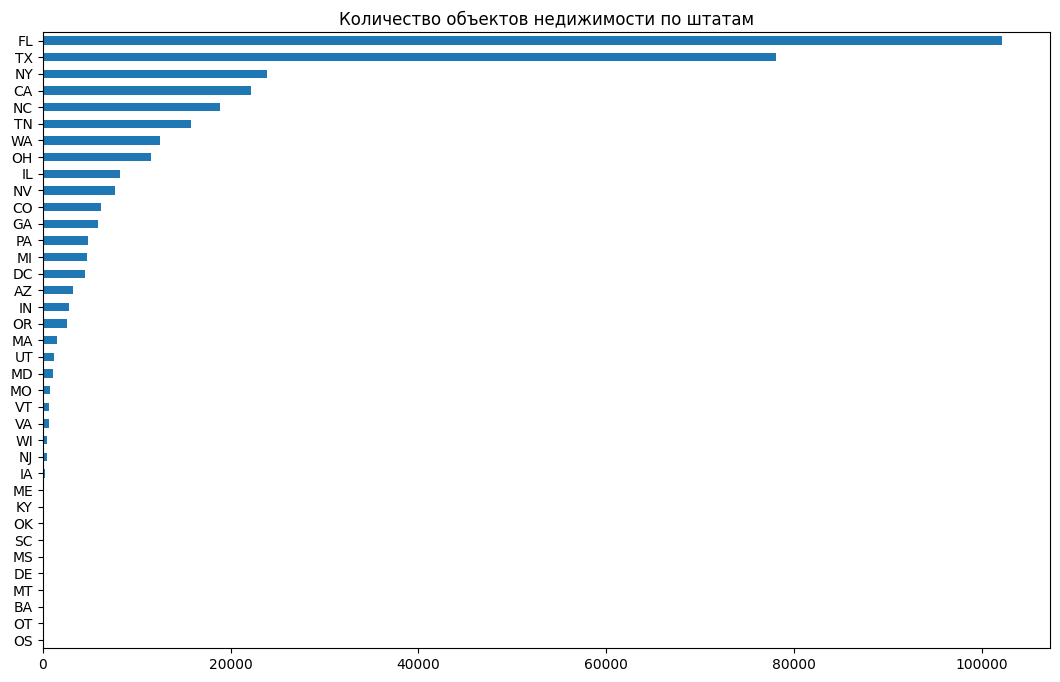

In [86]:
fig, ax = plt.subplots(figsize=(13, 8))
df['state'].value_counts(ascending = True).plot(kind = 'barh', ax=ax)
ax.set_title('Количество объектов недижимости по штатам');

### **--> Признак "city"**

In [87]:
df['city'] = df['city'].fillna('other') # Заменяем пропуски
top_city = df['city'].value_counts().nlargest(200).index

df['city'] = df['city'].apply(lambda x: x if x in top_city else 'other')

### **--> Признак "sqft"**

In [88]:
df.sqft = df.sqft.fillna('-1.0')

In [89]:
# Приводим в порядок признак
def make_features_sqft(x):
    x = x.replace('--', '0')
    x = re.sub('[^\-0-9]', '', x)
    if x== '610-840':
        x = '840'
    return x

df.sqft = df.sqft.apply(make_features_sqft)

In [90]:
df['sqft'] = df['sqft'].apply(lambda x: '0' if x=='' else x)
df['sqft'] = df['sqft'].astype(float)

### **--> Признак "baths"**

In [91]:
def is_num(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

def make_baths(x):
    x = re.sub('ba','Baths', x)
    x = re.sub('1 1/2', '1.5', x)
    x = x.replace('.0', '')
    x = x.replace('Bathsths','Baths')
    x = x.replace('7,500+','7,500')
    if x == 'Bathrooms: 241':
        x='4 Baths'
    if x == 'Bathrooms: SemiMod':
        x='6 Baths'
    if x == 'Sq. Ft. ':
        x = '0'
    x = x.replace('Bathrooms: ','')
    x = x.replace('Bathrooms: ','')
    x = x.replace('+','+ Baths')
    if x=='1 / 1-0 / 1-0 / 1-0' or x=='2-1 / 2-1 / 1-1 / 1-1':
        x = '2 Baths'
    if x=='1 / 1 / 1 / 1' or x=='1-0 / 1-0 / 1' or x=='3-1 / 2-2':
        x = '3'
    if x=='116 / 116 / 116':
        x='116 Baths'
    if x=='0 / 0' or x== '0.00' or x=='0.0' or x=='00' or x=='0 /':
        x='0'
    if (-1.0!=x.find('--') or -1.0!=x.find('~') or -1.0!=x.find('—')):
        x = '0'
    if is_num(x) and float(x)<120:
        x = x + ' Baths'
    return x

df.baths = df.baths.fillna('0')
df.baths = df.baths.apply(make_baths)

In [92]:
ind_Baths_top = df.baths.value_counts()[:50]
ind_Baths_top

2 Baths       100590
0 Baths        79894
3 Baths        64635
4 Baths        25905
1 Baths        16237
2.5 Baths      12589
5 Baths         9197
3.5 Baths       5282
6 Baths         4289
1,500           2207
7 Baths         2070
1.5 Baths       2061
2,000           1791
1,750           1720
3,000           1684
2,250           1440
4.5 Baths       1401
1,000           1279
1,250           1203
8 Baths         1156
2,750            964
2,500            894
3,500            653
9 Baths          544
5.5 Baths        399
10 Baths         327
4,000            289
2.5+ Baths       246
750              237
5,000            229
3.5+ Baths       210
11 Baths         186
4.5+ Baths       156
12 Baths         133
6.5 Baths        128
5.5+ Baths       123
1.75 Baths        87
13 Baths          74
6.5+ Baths        63
1.5+ Baths        55
16 Baths          52
2.1 Baths         49
14 Baths          45
2.75 Baths        34
7.5 Baths         34
18 Baths          32
7.5+ Baths        31
15 Baths     

### **--> Признак "beds"**

In [93]:
df['beds']= df['beds'].fillna('0')

In [94]:
df['beds_Baths'] = df['beds'].apply(lambda x: x if -1!=x.find('Bath') else ' ')
# Выделим  и сгруппируем для этих индексов данные признака 'baths'
ind_Baths =  df[df['beds_Baths']!=' '].index
# Удалим служебный признак
df.drop('beds_Baths', axis=1, inplace=True)

In [95]:
df.loc[ind_Baths, 'baths'] = df['baths'][ind_Baths].apply(lambda x: '1 Bath'
                                                          if x== '0 Baths' else x)

In [96]:
def make_beds(x):
    x = x.replace('bd','Beds')
    x = x.replace('1-2','2')
    x = x.replace('.0', '')
    x = x.replace('--', '0')
    if x=='Baths':
        x='Bath'
    if len(x)>0 and len(x)<=3 and x!='0':
        x = x + ' Beds'
    if( x==' ') or (x=='0 sqft') or (x=='0'):
        x='0 Beds'

    if x==' Beds' or x=='  Beds':
        x='1 Beds'
    if -1!=x.find('3 or More Bedrooms'):
        x = '3+ Beds'
    if -1!=x.find('2 Bedrooms'):
        x = '2 Beds'
    return x

df['beds'] = df['beds'].apply(make_beds)

In [97]:
# Имеются длинные данные, которые не имеют отношения к данному признаку. Их два,поставим 0.
df.beds = df.beds.apply(lambda x: '0 Beds' if len(x)>25 else x)

In [98]:
def is_num(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

acre_sqft = 43560

In [99]:
def acre_to_sqft(x):
    ed_izm = re.sub('[^A-Z a-z]', '', x).strip()
    value = re.sub('[^0-9\.]', '', x).strip()
    if ed_izm=='acres' or ed_izm=='acre':
        if is_num(value):
            value = round(float(value)*acre_sqft, 1)
            return str(value)+' '+ 'sqft'
        else:
            return value
    if ed_izm=='sqft'  or ed_izm=='':
        if is_num(value):
            value = round(float(value), 1)
            return str(value)+' '+ 'sqft'
        else:
            return value
    if ed_izm =='Beds' or ed_izm=='Bath':
        return x

df['beds'] = df['beds'].apply(acre_to_sqft)

Признак 'beds' - категориальный, но можно сделать числовым, разделив признак на два признака: 'count_beds' и 'sqft_beds'

In [100]:
df['sqft_beds'] = df['beds'].apply(lambda x: x if -1!=x.find('sqft') else '0')

df['sqft_beds'].value_counts()

0                340324
5000.0 sqft          90
43560.0 sqft         46
14810.4 sqft         39
12196.8 sqft         37
                  ...  
222591.6 sqft         1
3225.0 sqft           1
1210.0 sqft           1
252212.4 sqft         1
8479.0 sqft           1
Name: sqft_beds, Length: 992, dtype: int64

In [101]:
df['sqft_beds'] = df['beds'].apply(lambda x: float(re.sub('[^0-9\.]', '', x).strip())
                                   if -1!=x.find('sqft') else 0)

In [102]:
df['count_beds'] = df['beds'].apply(lambda x: x if (-1==x.find('sqft'))  else '0')

In [103]:
df['beds'] = df['beds'].apply(lambda x: '999 Beds' if -1!=x.find('Bath') else x)
df['count_beds'] = df['beds'].apply(lambda x: float(re.sub('[^0-9\.]', '', x).strip())
                                   if -1!=x.find('Beds') else 0)

In [104]:
df['count_beds'].value_counts()

3.0      104000
4.0       68122
0.0       67157
2.0       49124
5.0       21482
999.0     15992
6.0        6465
1.0        6428
7.0        1801
8.0        1190
9.0         476
10.0        270
12.0        185
11.0        132
16.0         68
13.0         46
14.0         42
15.0         32
18.0         31
24.0         30
20.0         19
17.0         12
32.0          9
28.0          9
22.0          8
26.0          8
19.0          6
21.0          5
23.0          5
34.0          5
27.0          5
30.0          4
40.0          4
44.0          3
36.0          3
25.0          3
47.0          2
42.0          2
33.0          2
48.0          2
78.0          2
29.0          2
35.0          1
76.0          1
46.0          1
52.0          1
75.0          1
39.0          1
144.0         1
53.0          1
99.0          1
31.0          1
88.0          1
Name: count_beds, dtype: int64

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343204 entries, 0 to 343203
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            343204 non-null  object 
 1   propertyType      343204 non-null  object 
 2   baths             343204 non-null  object 
 3   homeFacts         343204 non-null  object 
 4   city              343204 non-null  object 
 5   schools           343204 non-null  object 
 6   sqft              343204 non-null  float64
 7   zipcode           343204 non-null  object 
 8   beds              343204 non-null  object 
 9   state             343204 non-null  object 
 10  PrivatePool       343204 non-null  int64  
 11  target            343204 non-null  int64  
 12  Year_built        343204 non-null  float64
 13  Remodeled_year    343204 non-null  float64
 14  Heating           343204 non-null  object 
 15  Cooling           343204 non-null  object 
 16  Parking           34

In [106]:
#  Удаляется признаки: вспомогательные, рабочие и расщипленные на отдельные признаки
feature_drop = ['schools',  'homeFacts', 'beds', 'Price/sqft', 'lotsize', 'schools_Grades']
df.drop(feature_drop, axis=1, inplace=True)

In [107]:
df.to_csv (r'my_data.csv', index= False)

## Data preprocessing, Feature engineering

In [108]:
df = pd.read_csv('/content/drive/MyDrive/SkillFactory/Дипломный проект/my_data.csv')

In [109]:
top_status = df['status'].value_counts().nlargest(20)
df['status'] = df['status'].apply(lambda x: x if x in top_status else 'other')

In [110]:
top_baths = df['baths'].value_counts().nlargest(35)
df['baths'] = df['baths'].apply(lambda x: x if x in top_baths else 'other')

In [111]:
df['Heating'] = df['Heating'].apply(lambda x: 'Central Heating' if x == 'Central Heating' or x == 'Central' or x == 'Heating' else x)
df['Heating'] = df['Heating'].apply(lambda x: 'other' if x == 'Other' or x == 'other' else x)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343204 entries, 0 to 343203
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            343204 non-null  object 
 1   propertyType      343204 non-null  object 
 2   baths             343204 non-null  object 
 3   city              343204 non-null  object 
 4   sqft              343204 non-null  float64
 5   state             343204 non-null  object 
 6   PrivatePool       343204 non-null  int64  
 7   target            343204 non-null  int64  
 8   Year_built        343204 non-null  float64
 9   Remodeled_year    343204 non-null  float64
 10  Heating           343204 non-null  object 
 11  Cooling           343204 non-null  object 
 12  Parking           343204 non-null  int64  
 13  schools_rating    343204 non-null  float64
 14  schools_Distance  343204 non-null  float64
 15  school_count      343204 non-null  int64  
 16  sqft_beds         34

In [113]:
df.drop('Cooling', axis=1, inplace=True)

In [115]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = df.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['sqft',
 'PrivatePool',
 'target',
 'Year_built',
 'Remodeled_year',
 'Parking',
 'schools_rating',
 'schools_Distance',
 'school_count',
 'sqft_beds',
 'count_beds']

<ipython-input-116-9384a9b83744>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_target = df.corr()['target'].abs().sort_values()


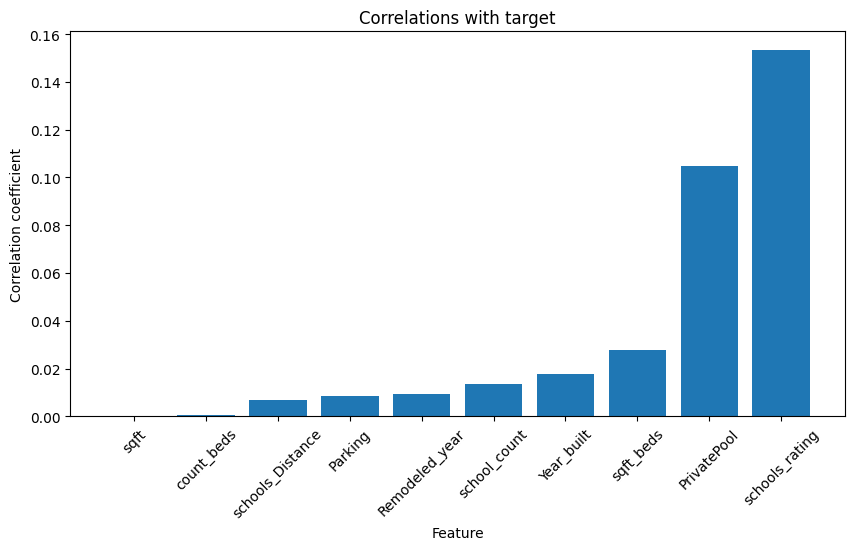

In [116]:
# Вычисляем модуль корреляции
corr_with_target = df.corr()['target'].abs().sort_values()
# Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('target')
# Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Сorrelation coefficient'); #название оси y

На данном графике мы можем увидеть взимосвязь числовых признаков и целевой переменной.

<ipython-input-117-d147e00d6857>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="RdYlGn");


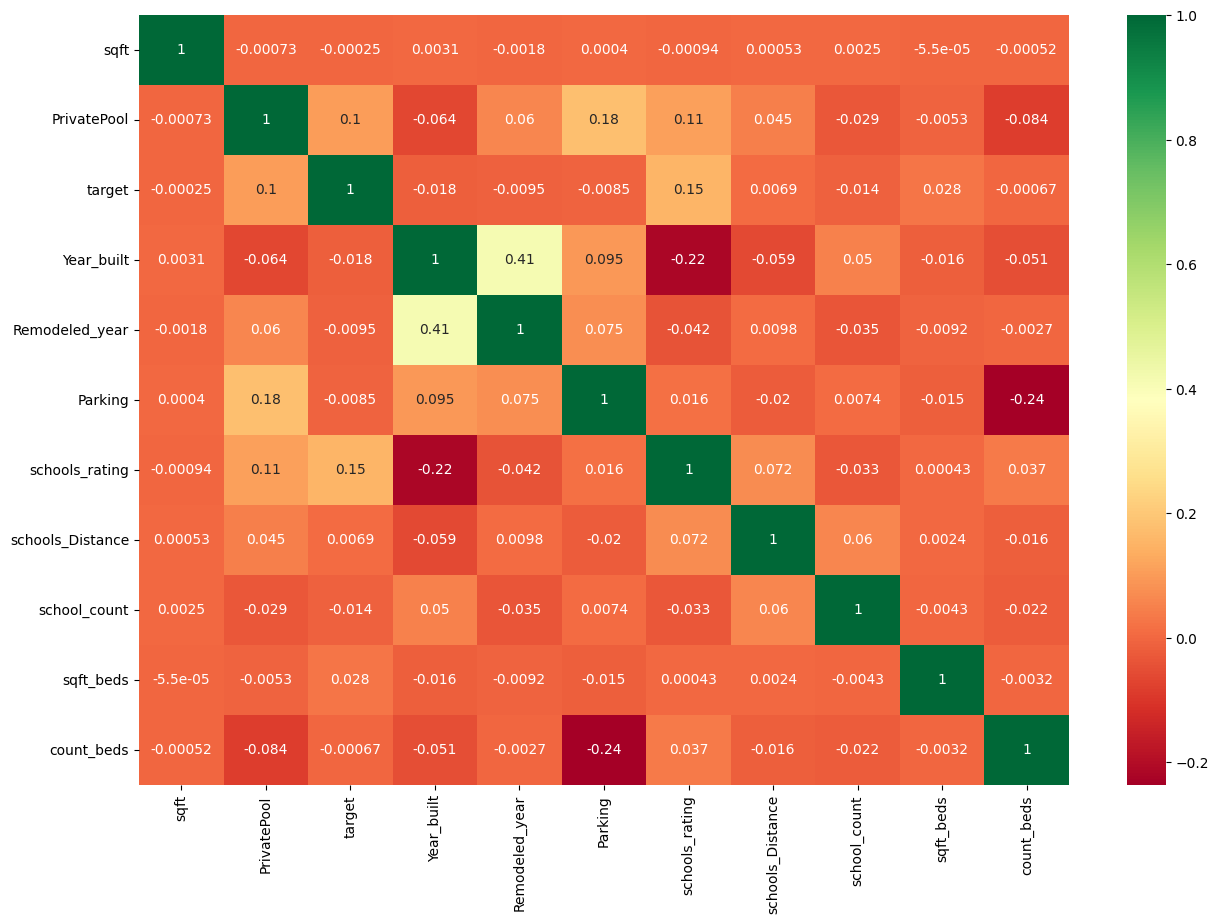

In [117]:
plt.rcParams['figure.figsize']=(15, 10)
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn");

In [118]:
df_1 = df.sample(n=30000)

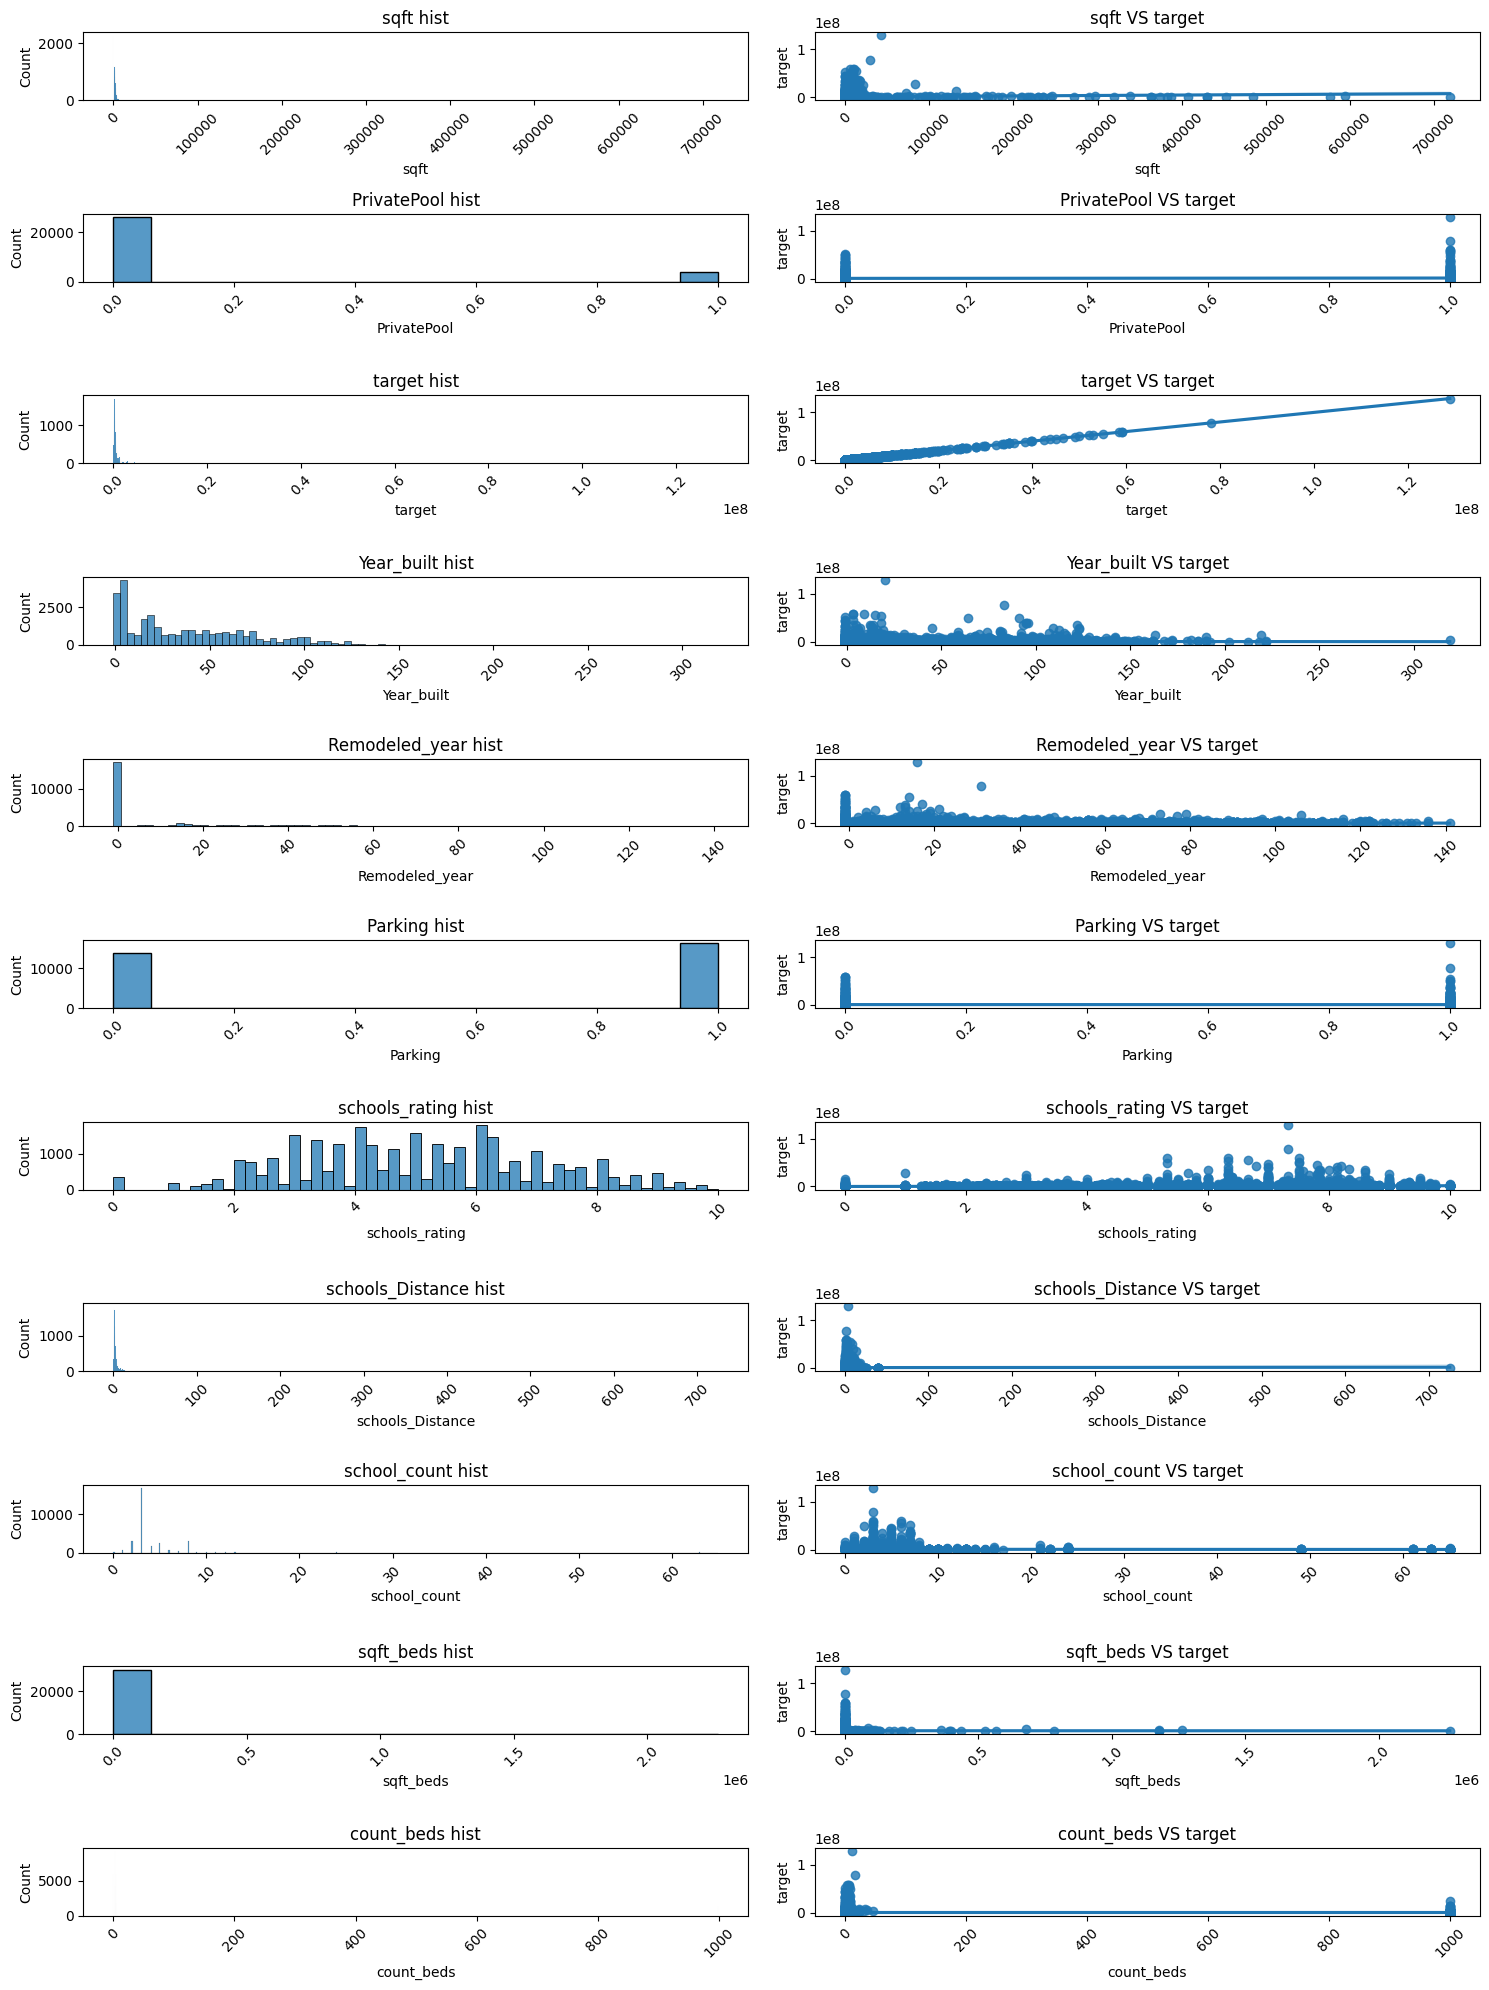

In [119]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака
    histplot = sns.histplot(data=df_1, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)

    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=df_1, x=feature, y='target', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS target'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

На графиках выше, мы видим распеделение числовых признаков, а также диаграмму рассеяния по каждому признаку + целевой, а также поверх диаграммы строится линейная зависимость по каждой паре признаков.

In [120]:
#Производим кодирование категориальных признаков
dummies_data = pd.get_dummies(df)
dummies_data.head(3)

,sqft,PrivatePool,target,Year_built,Remodeled_year,Parking,schools_rating,schools_Distance,school_count,sqft_beds,...,Heating_Hot Water,Heating_No,Heating_Oil,Heating_Radiant,Heating_Radiator,Heating_Refrigeration,Heating_Stove,Heating_Wall,Heating_Window Unit,Heating_other
0,2900.0,0,418000,3.0,-1.0,0,5.20,5.54,8,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1947.0,0,310000,3.0,-1.0,0,2.67,1.33,3,0.0,...,0,1,0,0,0,0,0,0,0,0
2,3000.0,1,2895000,61.0,54.0,1,6.67,1.96,3,0.0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
# X - матрица наблюдений, y - столбец правильных ответов
X = dummies_data.drop('target', axis=1)
y = dummies_data['target']

In [122]:
# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=40 #число отвечающее за генерацию случайных чисел
)
# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (274563, 356)
Test shape: (68641, 356)


In [123]:
# Функция для вывода метрик модели
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f} $'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('-' * 20)
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [124]:
# Строим baseline без преобразований
lr = LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [125]:
#Выводим результирующие метрики
print('LinearRegression без преобразований')
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

LinearRegression без преобразований
Train R^2: 0.269
Train MAE: 441723.942 $
Train MAPE: 488.358 %
--------------------
Test R^2: 0.286
Test MAE: 443194.649 $
Test MAPE: 1702.907 %


In [126]:
from sklearn.preprocessing import MinMaxScaler
#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Инициализируем объект класса линейная регрессия
sgd_lr = SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)

In [127]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.266
Train MAE: 448293.244 $
Train MAPE: 531.726 %
--------------------
Test R^2: 0.283
Test MAE: 449642.370 $
Test MAPE: 1620.423 %


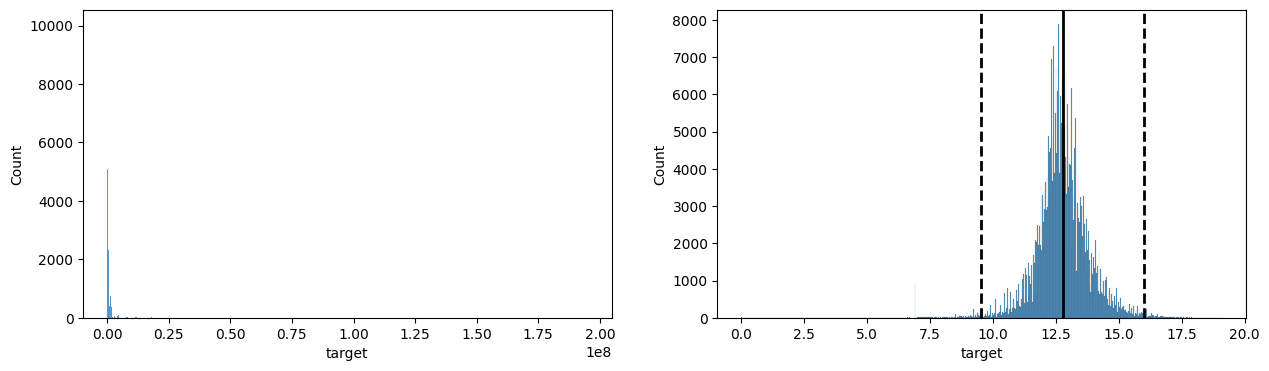

In [128]:
# Прологорифмируем несколько признаков, а также посмотрим на выбросы в данных
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df, x='target', ax=axes[0]);

#Логарифмируем
log_target = np.log(df['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);

#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='k', ls='--', lw=2);

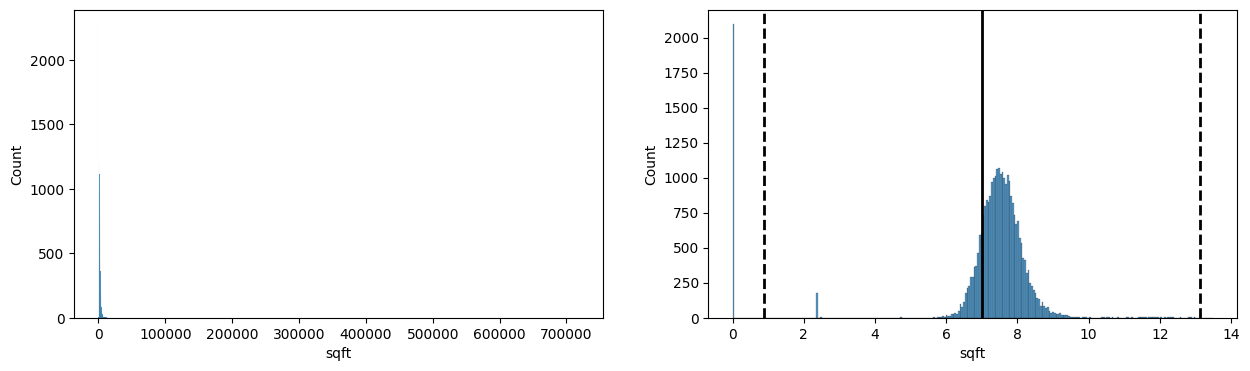

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_1, x='sqft', ax=axes[0]);

#Логарифмируем
log_sqft = np.log(df_1['sqft'] + 11)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft, ax=axes[1]);

#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_sqft.mean(), color='k', lw=2)
axes[1].axvline(log_sqft.mean()+ 3 *log_sqft.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_sqft.mean()- 3 *log_sqft.std(),
                color='k', ls='--', lw=2);

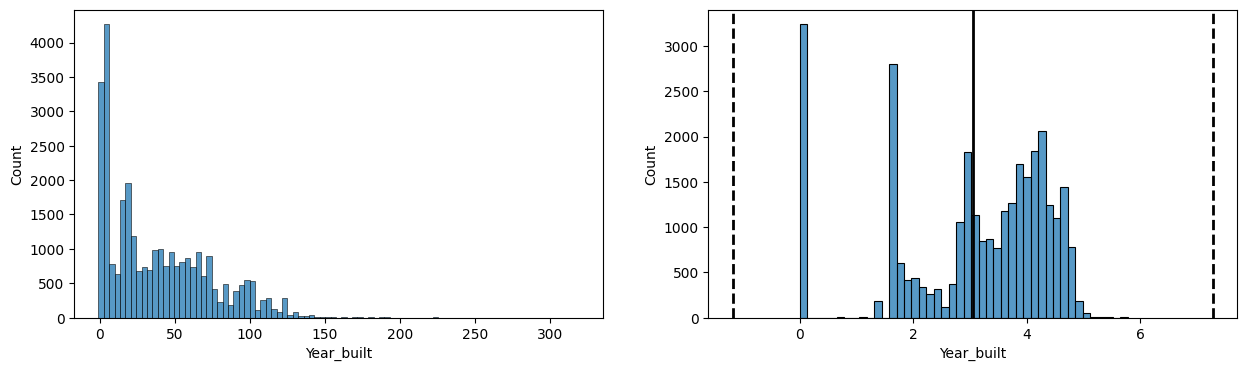

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_1, x='Year_built', ax=axes[0]);

#Логарифмируем
log_Year_built = np.log(df_1['Year_built'] +2)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_Year_built, ax=axes[1]);

#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_Year_built.mean(), color='k', lw=2)
axes[1].axvline(log_Year_built.mean()+ 3 *log_Year_built.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_Year_built.mean()- 3 *log_Year_built.std(),
                color='k', ls='--', lw=2);

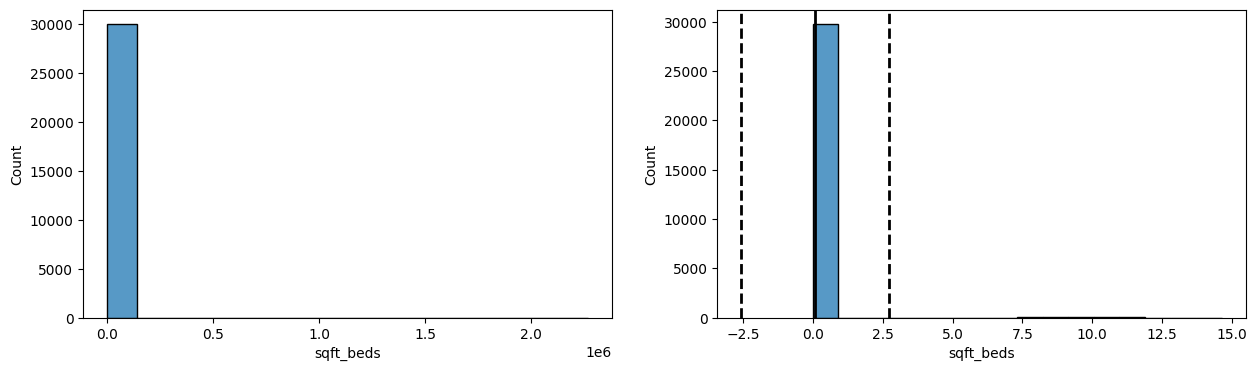

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_1, x='sqft_beds', ax=axes[0]);

#Логарифмируем
log_sqft_beds = np.log(df_1['sqft_beds'] + 1)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft_beds, ax=axes[1]);

#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_sqft_beds.mean(), color='k', lw=2)
axes[1].axvline(log_sqft_beds.mean()+ 3 *log_sqft_beds.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_sqft_beds.mean()- 3 *log_sqft_beds.std(),
                color='k', ls='--', lw=2);

In [132]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+11)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

#Производим очистку
outliers, temp_cleaned = outliers_z_score(df, 'target', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft_beds', log_scale=True)
print('Shape before cleaning outliers: {}'.format(df.shape))
print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))

Shape before cleaning outliers: (343204, 17)
Shape after cleaning outliers: (316022, 17)


In [133]:
df_cleaned = temp_cleaned.copy() # Очищенный датасет от выбросов

In [134]:
mask = df_cleaned['count_beds'] < 100
df_cleaned = df_cleaned[mask]

In [135]:
#Производим кодирование категориальных признаков
dummies_data = pd.get_dummies(df_cleaned)

In [136]:
dummies_data.shape

(302073, 349)

In [137]:
# X - матрица наблюдений, y - столбец правильных ответов
X = dummies_data.drop('target', axis=1)
y = dummies_data['target']
#Разделяем выборку на тренировочную и тестовую в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (241658, 348)
Test shape: (60415, 348)


Построим на предобработанных данных модель линейной регрессии

In [138]:
#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)

#Инициализируем объект класса линейная регрессия
lr = LinearRegression()
#Обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))

<ipython-input-138-a0f1b31bc984>:11: RuntimeWarning: overflow encountered in exp
  y_test_pred = np.exp(lr.predict(X_test))


In [139]:
print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_pred)))
print('Train MAE: {:.3f} $'.format(metrics.mean_absolute_error(y_train, y_train_pred)))
print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)*100))

Train R^2: 0.487
Train MAE: 230101.157 $
Train MAPE: 42.637 %


In [140]:
#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Train shape: {}'.format(X_train_scaled.shape))
print('Test shape: {}'.format(X_test_scaled.shape))

Train shape: (241658, 348)
Test shape: (60415, 348)


In [141]:
from sklearn.linear_model import Ridge
#Инициализируем объект класса линейная регрессия с L2-регуляризацией
ridge_lr_scaled = Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_scaled.fit(X_train_scaled, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr_scaled.predict(X_train_scaled))
y_test_pred = np.exp(ridge_lr_scaled.predict(X_test_scaled))

In [142]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.487
Train MAE: 230076.206 $
Train MAPE: 42.635 %
--------------------
Test R^2: 0.482
Test MAE: 228882.210 $
Test MAPE: 42.628 %


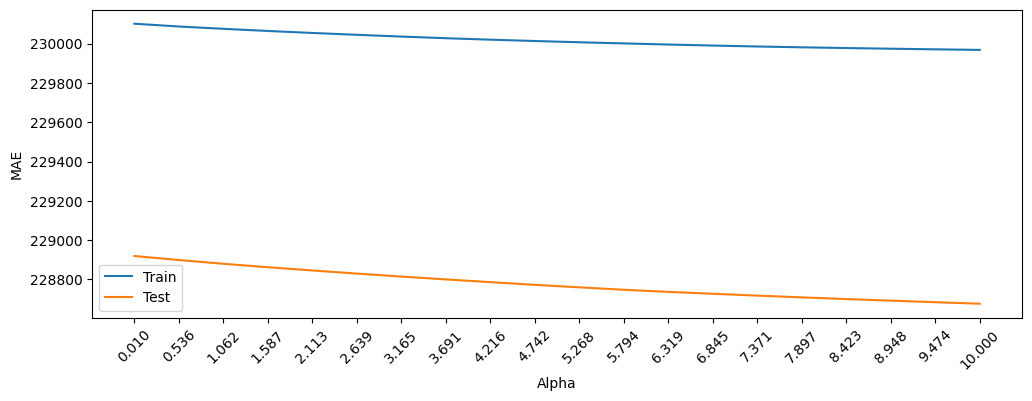

In [143]:
#Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
#Создаем пустые списки, в которые будем добавлять результаты
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_scaled = Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_scaled.fit(X_train_scaled, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_scaled = np.exp(ridge_lr_scaled.predict(X_train_scaled))
    y_test_predict_scaled = np.exp(ridge_lr_scaled.predict(X_test_scaled))
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_scaled))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_scaled))

#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

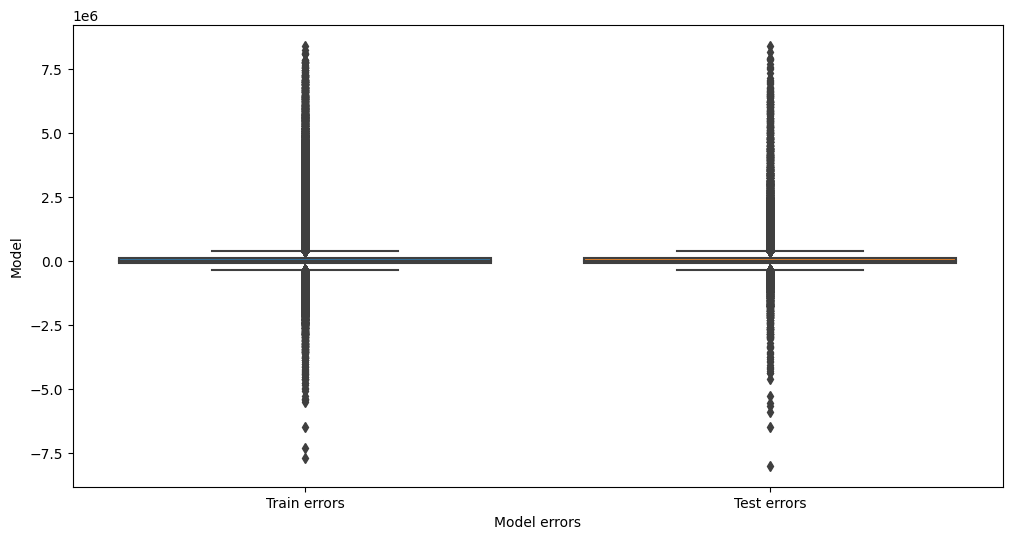

In [144]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке
y_train_errors = y_train - y_train_predict_scaled
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_predict_scaled
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors,
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [145]:
# Методы, основанные на F-тесте, оценивают степень линейной зависимости
# между двумя случайными величинами.  извлекаем лучшие 100 признаков.
bestfeatures = SelectKBest(score_func=f_regression, k=100)
fit = bestfeatures.fit(X_train, y_train)
# Создаем набор данных признаков с их весом и выбираем 100 лучших
featureScores =  pd.DataFrame({'Features':X_train.columns, 'Score': fit.scores_})
print(featureScores.nlargest(100,'Score'))

                     Features         Score
5              schools_rating  13138.506176
84              baths_7 Baths  12729.485465
83              baths_6 Baths  12540.358258
9                  count_beds  11142.675502
81              baths_5 Baths  10000.361416
..                        ...           ...
335        Heating_Forced Gas    118.681634
331          Heating_Electric    118.550865
37   propertyType_cooperative    113.203678
186         city_Lehigh Acres    112.997766
117           city_Cincinnati    112.701353

[100 rows x 2 columns]


In [146]:
# Пробуем с разным количеством признаков. Сначало выберем 100 признаков.
X_train_100 = X_train[featureScores.nlargest(100,'Score').Features.values]
X_test_100 = X_test[featureScores.nlargest(100,'Score').Features.values]

In [147]:
# baseline на 100 признаках
model_lr_100 = LinearRegression()
model_lr_100.fit(X_train_100, y_train)
y_train_pred = model_lr_100.predict(X_train_100)
y_test_pred = model_lr_100.predict(X_test_100)

In [148]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.467
Train MAE: 280697.314 $
Train MAPE: 70.147 %
--------------------
Test R^2: 0.470
Test MAE: 277928.265 $
Test MAPE: 69.797 %


In [149]:
# Дерево решений
dtr_100 = DecisionTreeRegressor(max_depth=12, random_state=42)
dtr_100.fit(X_train_100, y_train)
y_train_pred = dtr_100.predict(X_train_100)
y_test_pred = dtr_100.predict(X_test_100)

In [150]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.701
Train MAE: 219032.462 $
Train MAPE: 65.824 %
--------------------
Test R^2: 0.617
Test MAE: 234318.230 $
Test MAPE: 66.524 %


In [151]:
# Случайный лес
rf_clf = RandomForestRegressor(
    n_estimators=400, # число деревьев
    max_depth=11, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
rf_clf.fit(X_train_100, y_train)
y_train_pred = rf_clf.predict(X_train_100)
y_test_pred = rf_clf.predict(X_test_100)

In [152]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.584
Train MAE: 256013.927 $
Train MAPE: 85.160 %
--------------------
Test R^2: 0.562
Test MAE: 257446.243 $
Test MAPE: 84.937 %


In [153]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=7, min_samples_split=2, learning_rate=0.1)
clf.fit(X_train_100, y_train)
y_train_pred = clf.predict(X_train_100)
y_test_pred = clf.predict(X_test_100)

In [154]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.759
Train MAE: 187799.362 $
Train MAPE: 48.336 %
--------------------
Test R^2: 0.712
Test MAE: 194755.357 $
Test MAPE: 48.431 %


In [155]:
SGDR = SGDRegressor()
SGDR.fit(X_train_100, y_train)
y_train_pred = SGDR.predict(X_train_100)
y_test_pred = SGDR.predict(X_test_100)

In [156]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: -18113124983220871168.000
Train MAE: 843601025640534.625 $
Train MAPE: 256904214857.204 %
--------------------
Test R^2: -19791365144936218624.000
Test MAE: 850414955798625.250 $
Test MAPE: 258906811785.036 %


In [157]:
# Модель HistGradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train, y_train)
y_train_pred = GBR.predict(X_train)
y_test_pred = GBR.predict(X_test)

In [158]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.651
Train MAE: 221672.868 $
Train MAPE: 61.068 %
--------------------
Test R^2: 0.640
Test MAE: 222044.361 $
Test MAPE: 60.376 %


In [159]:
HGBR = HistGradientBoostingRegressor()
HGBR.fit(X_train, y_train)
y_train_pred = GBR.predict(X_train)
y_test_pred = GBR.predict(X_test)

In [160]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.651
Train MAE: 221672.868 $
Train MAPE: 61.068 %
--------------------
Test R^2: 0.640
Test MAE: 222044.361 $
Test MAPE: 60.376 %


In [161]:
ABR = AdaBoostRegressor()
ABR.fit(X_train, y_train)
y_train_pred = ABR.predict(X_train)
y_test_pred = ABR.predict(X_test)

In [162]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: -0.121
Train MAE: 573630.937 $
Train MAPE: 205.103 %
--------------------
Test R^2: -0.144
Test MAE: 571692.695 $
Test MAPE: 203.466 %


In [163]:
!pip install catboost

In [164]:
from catboost import CatBoostRegressor

CB = CatBoostRegressor()
CB.fit(X_train, y_train, verbose=False, plot=True)
y_train_pred = CB.predict(X_train)
y_test_pred = CB.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [165]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.815
Train MAE: 157609.410 $
Train MAPE: 36.885 %
--------------------
Test R^2: 0.776
Test MAE: 163370.708 $
Test MAPE: 37.280 %


Наилучшие результаты показала модель CatBoostRegressor(). Ошибка по стоимости недвижимсоти получилась 163.000 $.

Уверен можно добиться лучших результатов, но в силу ограниченности времени, пока остановился на этом результате.

А в целом, можно было попробовать провести более качественную предобработку данных, добавить новых признаков из внешних источников. И думаю, что качетсво модели можно не сомненно повысить.